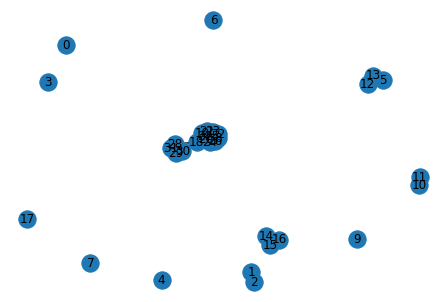

In [718]:
# libraries import
import os
import re
import json
import random
import itertools
import numpy as np
import networkx as nx
from scipy.stats import bernoulli

# fetching all the files
base_path = 'sequences/'
files = os.listdir(base_path)

# creating the Graph using networkx
G = nx.Graph()
node_index = 0

# main loop for graph construction
i = 0 # testing with just 1000 files
#for file in files:
while i < 50:
    # opening current file
    # print(files[i])
    with open(base_path + files[i]) as in_file:
        data = json.load(in_file)
    i += 1
    # isolating the comment section
    if 'comment' in data['results'][0]:
        comments_section = data['results'][0]['comment']

        # isolating the authors
        authors = []
        for comment in comments_section:
            pattern = '(_([a-zA-Z]+\.?\s?)*_)'
            results = re.findall(pattern, comment)
            if results:
                author = results[0][0].split('_')[1]
                authors.append(author)

        # adding the nodes
        for author in authors:
            if author not in nx.get_node_attributes(G, 'name').values():
                G.add_node(node_index, name = author)
                node_index += 1

        # adding the edges
        for pair in itertools.combinations(authors, 2):
            # fetching node 1
            node_1_key = list(nx.get_node_attributes(G, 'name').values()).index(pair[0])
            # fetching node 2
            node_2_key = list(nx.get_node_attributes(G, 'name').values()).index(pair[1])
            # adding the edge if it isn't already in the graph
            if (node_1_key, node_2_key) not in list(G.edges):
                G.add_edge(node_1_key, node_2_key)

nx.draw(G, with_labels = True)

Greedy algorithm O(m) for finding a MIS

In [720]:
def greedy_MIS(G):
    V_set = list(G.nodes).copy()
    maximal_independent_set = []
    while len(V_set) > 0:
        node = random.choice(V_set)
        maximal_independent_set.append(node)
        V_set.remove(node)
        for adj_node in list(G.adj[node]):
            if adj_node in V_set:
                V_set.remove(adj_node)
    return maximal_independent_set

Greedy algorithm O(m) for finding a MIS with the specified nodes in it

In [721]:
# function that returns a MIS with the specified nodes in it
def greedy_MIS_with_nodes_specified(G, chosen_nodes):
    V_set = list(G.nodes).copy()
    maximal_independent_set = []
    if check_if_set_is_IS(G, chosen_nodes):
        # inserting the chosen nodes and removing their adj list
        for node in chosen_nodes:
            maximal_independent_set.append(node)
            V_set.remove(node)
            for adj_node in list(G.adj[node]):
                if adj_node in V_set:
                    V_set.remove(adj_node)
        # main loop
        while len(V_set) > 0:
            node = random.choice(V_set)
            maximal_independent_set.append(node)
            V_set.remove(node)
            for adj_node in list(G.adj[node]):
                if adj_node in V_set:
                    V_set.remove(adj_node)
    return maximal_independent_set

Luby's algorithm O(logn) for finding a MIS

In [722]:
def luby_MIS(G):
    V_set = list(G.nodes).copy()
    E_set = list(G.edges).copy()
    maximal_independent_set = []
    while len(V_set) > 0:
        probability_dist = [1/(2*G.degree[node]) if G.degree[node] > 0 else 1 for node in V_set]
        marks = bernoulli.rvs(probability_dist, size = len(V_set))
        zip_iter = zip(V_set, marks)
        marked_nodes = dict(zip_iter)
        for edge in E_set:
            if marked_nodes[edge[0]] == 1 and marked_nodes[edge[1]] == 1:
                if G.degree[edge[0]] < G.degree[edge[1]]:
                    marked_nodes[edge[0]] = 0
                elif G.degree[edge[0]] > G.degree[edge[1]]:
                    marked_nodes[edge[1]] = 0
                else:
                    if edge[0] < edge[1]:
                        marked_nodes[edge[0]] = 0
                    else:
                        marked_nodes[edge[1]] = 0
        for idx, node in enumerate(V_set):
            if marked_nodes[idx] == 1:
                maximal_independent_set.append(node)
        for node in maximal_independent_set:
            V_set.remove(node)
            for adj_node in G.adj[node]:
                if adj_node in V_set:
                    V_set.remove(adj_node)
        for edge in E_set:
            if not(edge[0] in V_set and edge[1] in V_set):
                E_set.remove(edge)
    return maximal_independent_set

In [723]:
#luby_MIS(Gp)

Algorithm designed to find all MISs

In [724]:
# function that returns true if the set is independent (no 2 vertex build an edge of G)
def check_if_set_is_IS(G, IS):
    pairs = itertools.permutations(IS, 2)
    if any(pair in list(G.edges) for pair in pairs):
        return False
    else:
        return True

In [725]:
# function that returns true if the independent set is maximal (non-extendible)
def check_if_set_is_MIS(G, IS):
    nodes_without_IS = [node for node in list(G.nodes) if node not in IS]
    if any(is_node_addable_to_IS(G, IS, node) for node in nodes_without_IS):
        return False
    else:
        return True

In [726]:
# function that returns true if the node we're trying to add doesn't turn the set into
# a dependent set
def is_node_addable_to_IS(G, IS, new_node):
    if any(new_node in G.adj[node] for node in IS):
        return False
    else:
        return True

In [727]:
# function that returns a degeneracy ordering for the graph G
def get_degeneracy_ordering(G):
    deg_ordering = []
    graph = G.copy()
    degrees = dict(graph.degree)
    for i in range(graph.number_of_nodes()):
        min_degree_node = min(degrees, key = degrees.get)
        graph.remove_node(min_degree_node)
        del degrees[min_degree_node]
        deg_ordering.append(min_degree_node)
    return deg_ordering

In [983]:
# function that given a set A returns its minimum element according to the degeneracy 
# ordering provided
def get_minimum_elem_in_deg_ord(deg_ord, A):
    if None in A:
        return A[0]
    for node in deg_ord:
        if node in A:
            return node

In [914]:
# function that returns the complementary neighborhood of a specified node, that is all 
# the nodes that don't appear in its adjacency list. doesn't count duplicates.
def get_complementary_neighborhood(G, spec_node):
    compl_neighborhood = []
    for node in G.nodes:
        compl_neighborhood += [adj_node for adj_node in G.adj[node] if adj_node not in G.adj[spec_node] and adj_node != spec_node]
    return list(set(compl_neighborhood))

In [916]:
# function that returns the complementary neighborhood of a specified node set, that is all 
# the nodes that don't appear in the adjacency lists of the nodes in the set. doesn't count
# duplicates.
def get_set_complementary_neighborhood(G, A):
    compl_neighborhood = []
    for set_node in A:
        compl_neigh = get_complementary_neighborhood(Gp, set_node)
        compl_neighborhood.append(compl_neigh)
    intersection = set.intersection(*map(set,compl_neighborhood))
    return list(intersection)

In [753]:
# function that returns the neighbors of the nodes that come before the specified node
# in the degeneracy ordering
def get_neighbors_of_nodes_before_deg_ord(G, deg_ord, spec_node):
    adj_nodes = []
    for node in deg_ord:
        if node != spec_node:
            adj_nodes += G.adj[node]
        else:
            break
    return adj_nodes

In [765]:
# function that returns the intersection between the specified set A and the nodes that 
# appear before the specified node in the degeneracy order
def get_nodes_in_set_before_spec_deg_ord(deg_ord, A, spec_node):
    deg_ord_before_spec = set(deg_ord[:deg_ord.index(spec_node)])
    A_before_spec = [node for node in deg_ord_before_spec if node in A]
    return A_before_spec

In [976]:
# function that returns the intersection between the specified set A and the nodes that 
# appear before the specified node or at the specified node in the degeneracy order
def get_nodes_in_set_before_equal_spec_deg_ord(deg_ord, A, spec_node):
    deg_ord_before_spec = set(deg_ord[:deg_ord.index(spec_node)+1])
    A_before_spec = [node for node in deg_ord_before_spec if node in A]
    return A_before_spec

In [767]:
# function that returns the set I<v intersected with the complementary neighborhood of v,
# that is I'v
def get_I_prime_set(G, deg_ord, IS, spec_node):
    I_before_spec = get_nodes_in_set_before_spec_deg_ord(deg_ord, IS, spec_node)
    compl_neighborhood_spec = get_complementary_neighborhood(G, spec_node)
    I_prime = [node for node in I_before_spec if node in compl_neighborhood_spec]
    return I_prime

In [979]:
rev_deg_ordering

[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

In [980]:
get_minimum_elem_in_deg_ord(rev_deg_ordering, [0,2])

2

In [ ]:
def is_root(IS):
    

In [ ]:
def parent_state(IS):
    

In [ ]:
def get_next_candidate():

In [953]:
I = [0,2]
v = 6
i_prime = get_I_prime_set(Gp, deg_ord, I, v)
i_prime_before = get_nodes_in_set_before_spec_deg_ord(deg_ord, i_prime, v)
complete_MIS(Gp, i_prime_before + [v])

[0, 2, 6]

In [952]:
def complete_MIS(G, IS):
    V_set = get_set_complementary_neighborhood(G, IS)
    deg_ord = get_degeneracy_ordering(G)
    maximal_independent_set = []
    # main loop
    while len(V_set) > 0:
        node = get_minimum_elem_in_deg_ord(V_set, deg_ord) # take min
        IS.append(node)
        V_set.remove(node)
        for adj_node in list(G.adj[node]):
            if adj_node in V_set:
                V_set.remove(adj_node)
    return IS

In [988]:
def get_parent_index(G, IS, deg_ord):
    smallest = None
    for node in IS:
        before_equal_set = get_nodes_in_set_before_equal_spec_deg_ord(deg_ord, IS, node)
        if set(complete_MIS(G, IS)) == set(IS):
            if get_minimum_elem_in_deg_ord(deg_ord, [node, smallest]) == node:
                smallest = node
    return smallest

In [ ]:
def child_exist()

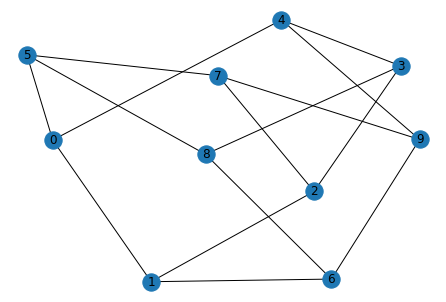

In [972]:
Gp = nx.petersen_graph()
nx.draw(Gp, with_labels = True)
deg_ordering = get_degeneracy_ordering(Gp)
rev_deg_ordering = deg_ordering[::-1]

In [729]:
def find_all_MIS_rec(G, node, V_set, adj_V_set, remaining_nodes, set_of_found_MIS):
    print(node, V_set, adj_V_set, remaining_nodes)
    
    if set(remaining_nodes) == set():
        return

    V_set.append(node)
    remaining_nodes.remove(node)
    for adj_node in G.adj[node]:
        if adj_node in remaining_nodes:
            remaining_nodes.remove(adj_node)
        if adj_node not in adj_V_set:
            adj_V_set.append(adj_node)
    
    if check_if_set_is_MIS(G, V_set):
        new_MIS = V_set.copy()
        if set(new_MIS) not in [set(MIS) for MIS in set_of_found_MIS]:
            print(V_set, adj_V_set, remaining_nodes, "<---")
            set_of_found_MIS.append(new_MIS)
        V_set.remove(node)
            
    if set(V_set + remaining_nodes) not in [set(MIS) for MIS in set_of_found_MIS]:
        for rem_node in remaining_nodes:
            if is_node_addable_to_IS(G, V_set, rem_node):
                find_all_MIS_rec(G, rem_node, V_set.copy(), adj_V_set.copy(), remaining_nodes.copy(), set_of_found_MIS)


In [731]:
def find_all_MIS(G):
    set_of_found_MIS = []
    V_set = []
    remaining_nodes = list(G.nodes).copy()
    # adding all nodes with degree 0
    for node in remaining_nodes:
        if G.degree[node] == 0:
            V_set.append(node)
    for node in V_set:
        remaining_nodes.remove(node)
    for node in remaining_nodes:
        adj_V_set = []
        if is_node_addable_to_IS(G, V_set, node):
            find_all_MIS_rec(G, node, V_set.copy(), adj_V_set.copy(), remaining_nodes.copy(), set_of_found_MIS)
    return set_of_found_MIS

In [733]:
def find_maximum_MIS(G):
    set_of_found_MIS = []
    V_set = []
    remaining_nodes = list(G.nodes).copy()
    # adding all nodes with degree 0
    for node in remaining_nodes:
        if G.degree[node] == 0:
            V_set.append(node)
    for node in V_set:
        remaining_nodes.remove(node)
    for node in remaining_nodes:
        adj_V_set = []
        if is_node_addable_to_IS(G, V_set, node):
            find_all_MIS_rec(G, node, V_set.copy(), adj_V_set.copy(), remaining_nodes.copy(), set_of_found_MIS)
    return max(set_of_found_MIS, key = len)

In [734]:
%%time
find_all_MIS(Gp)

0 [] [] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
2 [0] [1, 4, 5] [2, 3, 6, 7, 8, 9]
6 [0, 2] [1, 4, 5, 3, 7] [6, 8, 9]
[0, 2, 6] [1, 4, 5, 3, 7, 8, 9] [] <---
8 [0, 2] [1, 4, 5, 3, 7] [6, 8, 9]
9 [0, 2, 8] [1, 4, 5, 3, 7, 6] [9]
[0, 2, 8, 9] [1, 4, 5, 3, 7, 6] [] <---
9 [0, 2] [1, 4, 5, 3, 7] [6, 8, 9]
3 [0] [1, 4, 5] [2, 3, 6, 7, 8, 9]
6 [0, 3] [1, 4, 5, 2, 8] [6, 7, 9]
7 [0, 3, 6] [1, 4, 5, 2, 8, 9] [7]
[0, 3, 6, 7] [1, 4, 5, 2, 8, 9] [] <---
7 [0, 3] [1, 4, 5, 2, 8] [6, 7, 9]
9 [0, 3] [1, 4, 5, 2, 8] [6, 7, 9]
[0, 3, 9] [1, 4, 5, 2, 8, 6, 7] [] <---
6 [0] [1, 4, 5] [2, 3, 6, 7, 8, 9]
2 [0, 6] [1, 4, 5, 8, 9] [2, 3, 7]
3 [0, 6] [1, 4, 5, 8, 9] [2, 3, 7]
7 [0, 6] [1, 4, 5, 8, 9] [2, 3, 7]
7 [0] [1, 4, 5] [2, 3, 6, 7, 8, 9]
3 [0, 7] [1, 4, 5, 2, 9] [3, 6, 8]
6 [0, 7] [1, 4, 5, 2, 9] [3, 6, 8]
8 [0, 7] [1, 4, 5, 2, 9] [3, 6, 8]
[0, 7, 8] [1, 4, 5, 2, 9, 3, 6] [] <---
8 [0] [1, 4, 5] [2, 3, 6, 7, 8, 9]
2 [0, 8] [1, 4, 5, 3, 6] [2, 7, 9]
7 [0, 8] [1, 4, 5, 3, 6] [2, 7, 9]
9 [0, 8] [1, 4, 5, 3, 6] [

[[0, 2, 6],
 [0, 2, 8, 9],
 [0, 3, 6, 7],
 [0, 3, 9],
 [0, 7, 8],
 [1, 3, 5, 9],
 [1, 3, 7],
 [1, 4, 5],
 [1, 4, 7, 8],
 [1, 8, 9],
 [2, 4, 5, 6],
 [2, 4, 8],
 [2, 5, 9],
 [3, 5, 6],
 [4, 6, 7]]

In [732]:
find_maximum_MIS(Gp)

0 [] [] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
2 [0] [1, 4, 5] [2, 3, 6, 7, 8, 9]
6 [0, 2] [1, 4, 5, 3, 7] [6, 8, 9]
[0, 2, 6] [1, 4, 5, 3, 7, 8, 9] [] <---
8 [0, 2] [1, 4, 5, 3, 7] [6, 8, 9]
9 [0, 2, 8] [1, 4, 5, 3, 7, 6] [9]
[0, 2, 8, 9] [1, 4, 5, 3, 7, 6] [] <---
9 [0, 2] [1, 4, 5, 3, 7] [6, 8, 9]
3 [0] [1, 4, 5] [2, 3, 6, 7, 8, 9]
6 [0, 3] [1, 4, 5, 2, 8] [6, 7, 9]
7 [0, 3, 6] [1, 4, 5, 2, 8, 9] [7]
[0, 3, 6, 7] [1, 4, 5, 2, 8, 9] [] <---
7 [0, 3] [1, 4, 5, 2, 8] [6, 7, 9]
9 [0, 3] [1, 4, 5, 2, 8] [6, 7, 9]
[0, 3, 9] [1, 4, 5, 2, 8, 6, 7] [] <---
6 [0] [1, 4, 5] [2, 3, 6, 7, 8, 9]
2 [0, 6] [1, 4, 5, 8, 9] [2, 3, 7]
3 [0, 6] [1, 4, 5, 8, 9] [2, 3, 7]
7 [0, 6] [1, 4, 5, 8, 9] [2, 3, 7]
7 [0] [1, 4, 5] [2, 3, 6, 7, 8, 9]
3 [0, 7] [1, 4, 5, 2, 9] [3, 6, 8]
6 [0, 7] [1, 4, 5, 2, 9] [3, 6, 8]
8 [0, 7] [1, 4, 5, 2, 9] [3, 6, 8]
[0, 7, 8] [1, 4, 5, 2, 9, 3, 6] [] <---
8 [0] [1, 4, 5] [2, 3, 6, 7, 8, 9]
2 [0, 8] [1, 4, 5, 3, 6] [2, 7, 9]
7 [0, 8] [1, 4, 5, 3, 6] [2, 7, 9]
9 [0, 8] [1, 4, 5, 3, 6] [

[0, 2, 8, 9]